In [238]:
import pandas
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import sklearn.feature_extraction as fe
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
import sklearn.neighbors as nhb
import sklearn.ensemble as es
import sklearn.tree as tree
from sklearn import svm
import sklearn.naive_bayes as nb
import sklearn.linear_model as lm
from sklearn.metrics import classification_report, fbeta_score, make_scorer, log_loss, accuracy_score, roc_auc_score, brier_score_loss
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.calibration as cl

%matplotlib inline

In [129]:
train = pandas.read_csv('data/account_histroy_data.csv')
test = pandas.read_csv('data/existing_account.csv')

In [130]:
train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [131]:
train = train.drop(labels = ['RowNumber', 'CustomerId', 'Surname'], axis=1)
train = train.replace({'Gender': {'Female': 0, 'Male': 1}})
train = train.rename(columns={'Gender': 'IsMale'})

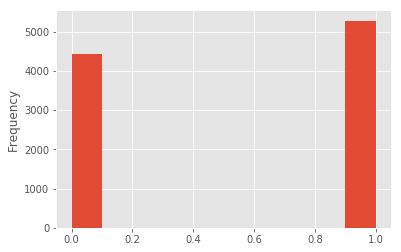

In [132]:
matplotlib.style.use('ggplot')
train['IsMale'].plot.hist()

# Initial analysis

* `RowNumber`, `CustomerID` and `Surname` can be dropped 
* `CreditScore` whilst numerical should be treated more like a ordinal variable. Nice and normal distribution. No missing values
* `Age` is nicely behaved: no missing values, nice and finite, nice and normally distributed
* `Tenure` is similarly nicely behaved: no missing values, finitely bounded and practically uniformally distributed. What does this variable represent? Age of account?
* `Balance` is a bit more interesting: there's a large spike at ~<= 30k and then a normally distributed group centered at just over 100k. This suggests 2 separate populations. No na values
* `NumOfProducts` is uninteresting: no missing values, all integers in [1,4]. All same order of magnitude
* `HasCrCard` binary variable indicating credit card ownership. No missing values. Distribution of both classes is same order of magnitude, positive value (`1`) outweighs `0` value by about 4k occurences.
* `IsActiveMember` binary variable. Practically class sizes. No missing values.
* `EstimatedSalary` nicely behaved: uniform distribution with no missing values and all values in the same order of magnitude.
* `Exited` Target variable. 1 indicates customer left, inbalanced classes with most cases in the "stayed" category.

# Potential process

* Given we don't have to worry about missing values, send the data straight to an `sklearn DictVectoriser` (as we want to track column names) followed by `OneHotEncoder` to handle binary variables that 
* This will automatically handle binarising our categorical variables.
* Most variables were normally or uniformally distributed, so standard scaling should be sufficient, but test with robust scaling as well.
* We've got enough data points that we can comfortable affort to slice off a portion of the dataset as a validation set. This can be done post scaling, pre test-train split. This will help prevent overfitting.
* The class imbalance isn't too bad (they're both on the same order of magnitude), but it would be worth testing over/under/synthetic sampling approaches anyways.
* We're treating this as a classification exercise, so let's run it across Naive Bayes, some forests of trees, gradient boosting, SVM's. As a baseline/sanity check let's run super basic logistic and single-tree models as well. ~~Bigger~~ Fancier isn't always better.
* Model stacking and voting classifiers (soft and hard) are also worth investigating

In [133]:
train[train['EstimatedSalary'].isna()]

,CreditScore,Geography,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


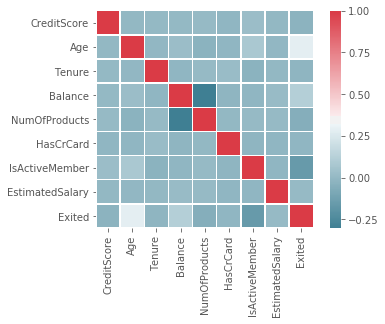

In [134]:
corr = train[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']].corr()
camp = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr, cmap=camp, square=True, linewidths=0.5)

# Correlation Matrix
While it appears pretty uniform at first glance, there's some interesting stuff lurking here: whilst most of the variables exhibit near 0 correlation, there's some positive correlation between `age` and `exited` and some (relatively) strong negative correlation between `NumOfProducts` and `Balance`. There's also a weak negative correlation between `IsActiveMember` and `Exited`; possibly too weak to be useful, but worth keeping in mind.

# Feature Engineering
What features can we make that will add something meaningful and useful?
* Balance / NumOfProducts?
* EstimatedSalary

In [135]:
# Let's slice off a validation set now so we can completely isolate it from the train and test data.
validation = train[['CreditScore', 'Geography', 'IsMale', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']].sample(frac=0.1)
train2 = train[~train.index.isin(validation.index)]# Drop the validation values from the primary train set

In [314]:
train2.head()

,CreditScore,Geography,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [309]:
def sep_target(data):
    cols = data.columns
    target = data['Exited']
    rem = data[cols.drop('Exited')]
    return rem, target
def re_order_unbind(data): 
    re_ordering = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'IsMale', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain']
    num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    cat_cols = ['IsMale', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain']
    data = data[re_ordering]
    numerical = data[num_cols]
    categorical = data[cat_cols]
    return numerical, categorical
def scale_rebind(num, cat):
    scalefn = pp.StandardScaler()
    scaled = scalefn.fit_transform(num)
    return np.concatenate([scaled, cat], axis=1)

In [316]:
# Lots of algorithms expect (and perform better) when data is in the same scale. However, it doesn't much sense to scale categorical variables, so we re-order the dataset for ease of interpretation then separate it
# into numerical and categorical sections, scale the numerical data and then rejoin everything back into the one dataset. Turning it into a function means we have a nice, single place to change our scaling type
# later if we want to test other types.

X,Y = sep_target(train2)
tempX = pandas.get_dummies(X)  # Splits categorical/text columns containing n categories into n binary variables
Xn, Xc = re_order_unbind(tempX)
Xs = scale_rebind(Xn, Xc)

valX, valY = sep_target(validation)
temp_valX = pandas.get_dummies(valX)
valXn, valXc = re_order_unbind(temp_valX)
valXs = scale_rebind(valXn, valXc)

# Thoughts on ML/fitting process

We are trying to predict whether a user will leave/stop being a customer. We have a large choice of metrics with which to evaluate estimator performance. Measuring model confidence via probabilities would be ideal as it will let us generate the `log-loss` metric which means we can optimise for an estimator that is not "confidently wrong" which would result in lost clients. Outputting probabilities is also useful because it would give the sales/retention/etc team the ability to prioritise certain customers based on how likely they are to churn. `F1` or `Fbeta` score would probably be the next best metric to evaluate with. Weighting for `Fbeta` could go either way. On one hand we don't want to raise false-positives on clients that weren't going to churn because this wastes sales' effort (but has no negative effect on the customer), but weighting too heavily for precision could lead to potential churn-customers being lost in order for the model to preserve the accuracy of the ones it is confident in.

In [317]:
models = {
    'svm': svm.SVC(),
    'svm_poly': svm.SVC(),
    'knn': nhb.KNeighborsClassifier(),
    'naive_bayes': nb.GaussianNB(),
#     'decision_tree': tree.DecisionTreeClassifier(),
    'random_forest': es.RandomForestClassifier(),
    'adaBoost': es.AdaBoostClassifier(),
    'Gradient_Boosting': es.GradientBoostingClassifier(),
    'Logistic_Regression': lm.LogisticRegression()
    #'Voting classifier'
}

In [321]:
# {'C': 0.5, 'class_weight': 'balanced', 'coef0': 0.4, 'degree': 3, 'gamma': 0.3, 'kernel': 'poly', 'probability': True, 'random_state': 74}
svm_params = {'C': [1, 0.5, 0.1], 'kernel': ['linear', 'rbf',], 'gamma': ['auto', 0.3], 
             'probability': [True], 'class_weight': ['balanced', None], 'random_state': [74]}
svm_poly_params = {'C': [0.5, 0.8, 0.25], 'kernel': ['poly'], 'degree': [2,3,5], 'gamma': ['auto', 0.1, 0.3], 'coef0': [0, 0.4, 0.6],
                'probability': [True], 'class_weight': ['balanced', None], 'random_state': [74]},
knn_params = {'n_neighbors': [3, 5, 9, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['kd_tree']}
nb_params = None
tree_params = None
forest_params = {'n_estimators': [50, 80, 150, 200, 250], 'max_features': ['auto', None, 0.5,0.8], 'min_samples_split': [0.3, 0.5, 0.8],
                'bootstrap': [True, False], 'n_jobs': [-1], 'random_state': [74], 'class_weight': ['balanced', None, 'balanced_subsample'], 'warm_start': [False]}
ada_params = {'n_estimators': [30, 40, 50, 80, 100, 150], 'learning_rate': [0.1, 0.2, 0.3, 0.35, 0.25], 'random_state': [74]},
gb_params = {'learning_rate': [0.1, 0.05], 'n_estimators': [100, 200, 300, 400, 500, 600], 'max_depth': [3, 6, 10], 'min_samples_split': [0.5, 0.3, 0.75],
            'min_samples_leaf': [1,3, 0.5, 0.2], 'subsample': [0.5, 1], 'max_features': [None, 'auto'], 'random_state': [74]}
logistic_params = {'C': [1, 0.75, 0.6, 0.4], 'class_weight': ['balanced', None], 'random_state': [74], 'max_iter': [300], 'warm_start': [True, False], 'n_jobs': [-1]}
voting_params = None
params = {'svm': svm_params,
          'svm_poly': svm_poly_params,
          'knn': knn_params,
#           'decision TREE': tree_params,
          'random_forest': forest_params,
          'adaBoost': ada_params,
          'Gradient_Boosting': gb_params,
          'Logistic_Regression': logistic_params}
#           'Voting classifier': voting_params}  # Leave this one out until we've got some good models to vote with

In [322]:
# We're going to build the models to optimise for recall first, then model stack with the best one(s) and then build a 2nd generation of models optimising for precision/log-loss.
for model, parameters in params.items():
    print()
    print()
    print(f'Testing model: {model}')
    clf = GridSearchCV(estimator=models[model],
                       param_grid=parameters,
                       cv=5,
                       scoring='recall',
                       n_jobs=-1,
                      refit='recall')
    clf.fit(Xs, Y)
    print(clf.best_params_)
    print(clf.n_splits_)
    est = clf.best_estimator_
    y_pred = est.predict(valXs)
    print(classification_report(valY, y_pred))



Testing model: svm
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.3, 'kernel': 'rbf', 'probability': True, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.92      0.76      0.83       767
          1       0.45      0.74      0.56       203

avg / total       0.82      0.76      0.78       970



Testing model: svm_poly
{'C': 0.25, 'class_weight': 'balanced', 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'probability': True, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.91      0.75      0.82       767
          1       0.43      0.72      0.54       203

avg / total       0.81      0.75      0.76       970



Testing model: knn
{'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'distance'}
5
             precision    recall  f1-score   support

          0       0.86      0.91      0.88       767
          1       0.56      0.43      0.49       203

avg / total      

/home/tomwatson/.local/share/virtualenvs/task2-rEKsIwwa/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'learning_rate': 0.35, 'n_estimators': 150, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.86      0.95      0.90       767
          1       0.69      0.43      0.53       203

avg / total       0.83      0.84      0.83       970



Testing model: Gradient_Boosting
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.3, 'n_estimators': 600, 'random_state': 74, 'subsample': 1}
5
             precision    recall  f1-score   support

          0       0.87      0.95      0.91       767
          1       0.69      0.46      0.55       203

avg / total       0.83      0.84      0.83       970



Testing model: Logistic_Regression


/home/tomwatson/.local/share/virtualenvs/task2-rEKsIwwa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/tomwatson/.local/share/virtualenvs/task2-rEKsIwwa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/tomwatson/.local/share/virtualenvs/task2-rEKsIwwa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/tomwatson/.local/share/virtualenvs/task2-rEKsIwwa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got

{'C': 1, 'class_weight': 'balanced', 'max_iter': 300, 'n_jobs': -1, 'random_state': 74, 'warm_start': True}
5
             precision    recall  f1-score   support

          0       0.90      0.72      0.80       767
          1       0.40      0.69      0.51       203

avg / total       0.79      0.72      0.74       970



/home/tomwatson/.local/share/virtualenvs/task2-rEKsIwwa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


# Preliminary Results:
* Plain SVM's performed average at best, with middling precision but good recall: `0.49` and `0.72` respectively and `0.58` for the f1 score.
* Polynomial SVM's performed better with improvements to precision, recall and f1 score: `0.5`, `0.74` and `0.6` respectively.
Optimising precision and recall is a tradeoff, but for our case, because we don't want to risk losing customers, we want to bias slightly towards recall.
* Plain random forests and adaBoost haven't been too suitable for our use-case: they both perform exceedingly well with regards to precision - scoring `0.81` and `0.94` respectively but very poorly when it comes to recall with both models scoring `<= 0.1` for the target value (left). This isn't ideal as it means that whilst their predictions for customers leaving are accurate (they're generating very few false positives), they're essentially underestimating/underpredicting the number of customers who would leave. That is, in production, they would not flag a large percentage of customers who are about to leave.
* There is an upside, we can still make use of the high precision of these models by using model-stacking. This is where we'll use a model (adaBoost and svm_poly in this case) to generate predictions for all samples in the greater training and validation set (`Xs` and `valXs`) and these add a column in each dataset. We'll then train another model using this new dataset, this allows us to guide/help successive models with extra information.

# Best models so far:
Polynomial SVM  
```
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.3, 'kernel': 'rbf', 'probability': True, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.92      0.76      0.83       767
          1       0.45      0.74      0.56       203

avg / total       0.82      0.76      0.78       970```  
Gradient Boosting Trees  
```
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.3, 'n_estimators': 600, 'random_state': 74, 'subsample': 1}
5
             precision    recall  f1-score   support

          0       0.87      0.95      0.91       767
          1       0.69      0.46      0.55       203

avg / total       0.83      0.84      0.83       970```


In [218]:
#Confusion matrix
#Let's roll with the polynomial SVM for now, as that seems to have the best balance.

# Model Improvements

Once we have a couple of models that we're reasonably happy with, we can run probability calibration on them. This will ideally have the effect of minimising the effects of over-confidence/underconfidence. As a result.

Plain SVM:  
`{'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.3, 'kernel': 'rbf', 'probability': True, 'random_state': 74}`  
and Gradient Boosted Trees:  
`{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.3, 'n_estimators': 600, 'random_state': 74, 'subsample': 1}`  
Check log-loss and ROC-AUC stats for these, then see if their probability-calibrated versions yield any improvements.

In [266]:
clf = svm.SVC(C=0.8, class_weight='balanced', coef0=0.6, degree=3, gamma='auto', kernel='poly', probability=True, random_state=74)
clf2 = clf.fit(Xs, Y)
uncalibrated = clf2.predict_proba(valXs)[:,1]
clb = cl.CalibratedClassifierCV(base_estimator=svm.SVC(C=0.8, class_weight='balanced', coef0=0.6, degree=3, gamma='auto', kernel='poly', probability=True).fit(Xs, Y), cv='prefit', method='sigmoid')
clb = clb.fit(Xs, Y)
calibrated = clb.predict_proba(valXs)[:,1]
print(f'No calibration: {brier_score_loss(valY, uncalibrated)}')
print(f'Sigmoid calibration: {brier_score_loss(valY, calibrated)}')

No calibration: 0.11048031215674682
Sigmoid calibration: 0.11068407528511306


# Results

Interestingly, probability calibration seems ever-so-slightly worsen the Brier score, but the change is very small (order of 1x10^-4) and Brier score is a `[0, 1]` bounded metric, so our score of `~0.110`  
is already quite good.  
Running the original and calibrated models against the validation set to compare:

In [256]:
ypred = clf2.predict(valXs)
print(classification_report(valY, ypred))
print(accuracy_score(valY, ypred))
print(log_loss(valY, ypred))  # Our model is a ~~little bit~~ very overconfident
print(roc_auc_score(valY, ypred))  # ROC AUC score looks good though

             precision    recall  f1-score   support

          0       0.92      0.80      0.86       767
          1       0.50      0.75      0.60       203

avg / total       0.83      0.79      0.80       970

0.790721649484536
7.228343450490987
0.7752968831285605


In [262]:
ypred = clb.predict(valXs)
print(classification_report(valY, ypred))
print(accuracy_score(valY, ypred))
print(log_loss(valY, ypred))  # Still very over-confident, but an improvement
print(roc_auc_score(valY, ypred))

             precision    recall  f1-score   support

          0       0.88      0.95      0.91       767
          1       0.74      0.49      0.59       203

avg / total       0.85      0.86      0.85       970

0.8577319587628865
4.913792915884259
0.7234892518352484


Run across the validation set we can see good improvements in accuracy and log-loss. ROC AUC score has decreased a small, almost negligible amount.
Seems the calibration has pushed the model towards increased precision at the cost of some recall.
Given we want to bias towards increased recall, let's use the uncalibrated model to model stack with, and then train a model that focuses heavily on precision and log-loss.

In [269]:
train_stack = clf2.predict(Xs)
val_stack = clf2.predict(valXs)

In [267]:
Xs.shape

(8729, 12)

In [271]:
Xs[0,:]

array([-0.32612953, -1.09562919,  0.28969876, -1.04365974, -1.21826603,
       -0.91386531,  0.64329791,  0.97253868,  0.01798931,  0.99965638,
       -0.57783531, -0.57660066])